170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0154 - val_loss: 0.0057
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0036 - val_loss: 0.0035
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


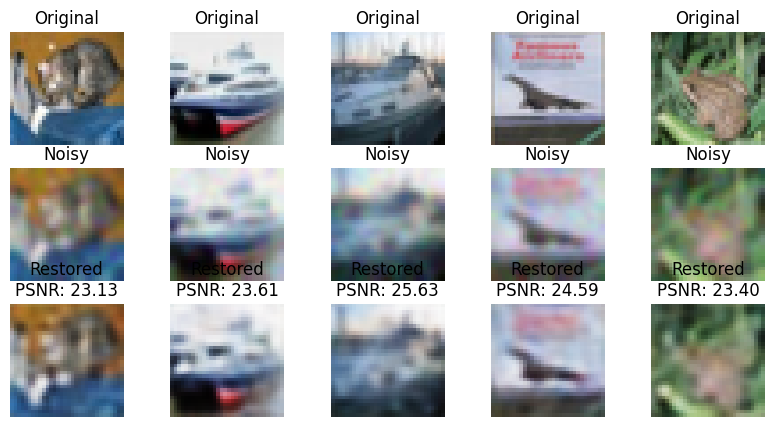

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10

(x_train, _), (x_test, _) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

input_shape = (32, 32, 3)

def add_noise_and_blur(images):
    noisy_images = []
    for img in images:
        noisy_img = img + 0.1 * np.random.normal(0, 1, img.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        blurred_img = cv2.GaussianBlur(noisy_img, (5,5), 0)
        noisy_images.append(blurred_img)
    return np.array(noisy_images)

x_train_noisy = add_noise_and_blur(x_train)
x_test_noisy = add_noise_and_blur(x_test)

def build_autoencoder():
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(input_img, decoded)
    return model

autoencoder = build_autoencoder()
autoencoder.compile(optimizer=Adam(), loss='mse')

autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=64, validation_data=(x_test_noisy, x_test))

def compute_psnr(original, restored):
    mse = np.mean((original - restored) ** 2)
    return 20 * np.log10(1.0 / np.sqrt(mse)) if mse > 0 else 100  # PSNR formula

predictions = autoencoder.predict(x_test_noisy)

num_images = 5
plt.figure(figsize=(10, 5))

for i in range(num_images):
    plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.title("Original")

    plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
    plt.title("Noisy")

    plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.title(f"Restored\nPSNR: {compute_psnr(x_test[i], predictions[i]):.2f}")

plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar100


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

print(f"Train Data: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test Data: {x_test.shape}, Labels: {y_test.shape}")


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Train Data: (50000, 32, 32, 3), Labels: (50000, 100)
Test Data: (10000, 32, 32, 3), Labels: (10000, 100)


In [ ]:
def build_alexnet(input_shape, num_classes):
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),  # Define Input Layer

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),  # Avoid reducing feature map to 0

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

alexnet = build_alexnet((32, 32, 3), 100)
alexnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
alexnet.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,618,980 (9.99 MB)

 Trainable params: 2,618,980 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
base_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

for layer in base_vgg16.layers:
    layer.trainable = False

vgg16 = Sequential([
    base_vgg16,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')
])

vgg16.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
vgg16.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,028,644 (57.33 MB)

 Trainable params: 313,956 (1.20 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
epochs = 10
batch_size = 64

start_time = time.time()
alexnet_history = alexnet.fit(x_train, y_train, validation_data=(x_test, y_test),
                              epochs=epochs, batch_size=batch_size)
alexnet_time = time.time() - start_time
print(f"AlexNet Training Time: {alexnet_time:.2f} sec")

start_time = time.time()
vgg16_history = vgg16.fit(x_train, y_train, validation_data=(x_test, y_test),
                           epochs=epochs, batch_size=batch_size)
vgg16_time = time.time() - start_time
print(f"VGG16 Training Time: {vgg16_time:.2f} sec")


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.0120 - loss: 4.5628 - val_accuracy: 0.0550 - val_loss: 4.0753
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.0598 - loss: 4.0435 - val_accuracy: 0.1183 - val_loss: 3.7609
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.1131 - loss: 3.7231 - val_accuracy: 0.1758 - val_loss: 3.4103
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.1574 - loss: 3.4790 - val_accuracy: 0.2113 - val_loss: 3.2164
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1875 - loss: 3.3073 - val_accuracy: 0.2305 - val_loss: 3.1408
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.2137 - loss: 3.1860 - val_accuracy: 0.2594 - val_loss: 2.9969
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.2398 - loss: 3.0598 - val_accuracy: 0.2646 - val_loss: 2.9602
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.2570 - loss: 2.9674 - val

In [ ]:
alexnet_eval = alexnet.evaluate(x_test, y_test, verbose=0)
vgg16_eval = vgg16.evaluate(x_test, y_test, verbose=0)

print(f"AlexNet Test Accuracy: {alexnet_eval[1]:.4f}, Loss: {alexnet_eval[0]:.4f}")
print(f"VGG16 Test Accuracy: {vgg16_eval[1]:.4f}, Loss: {vgg16_eval[0]:.4f}")


AlexNet Test Accuracy: 0.3090, Loss: 2.7346
VGG16 Test Accuracy: 0.3725, Loss: 2.4819


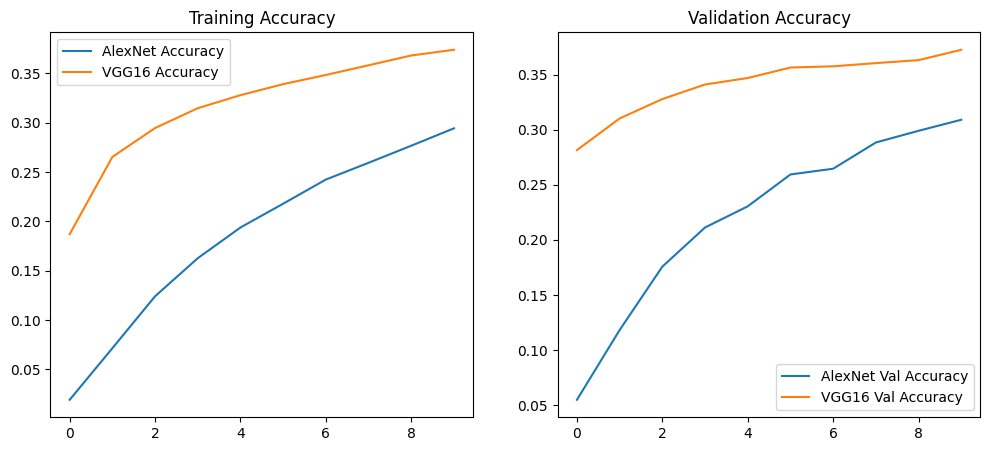

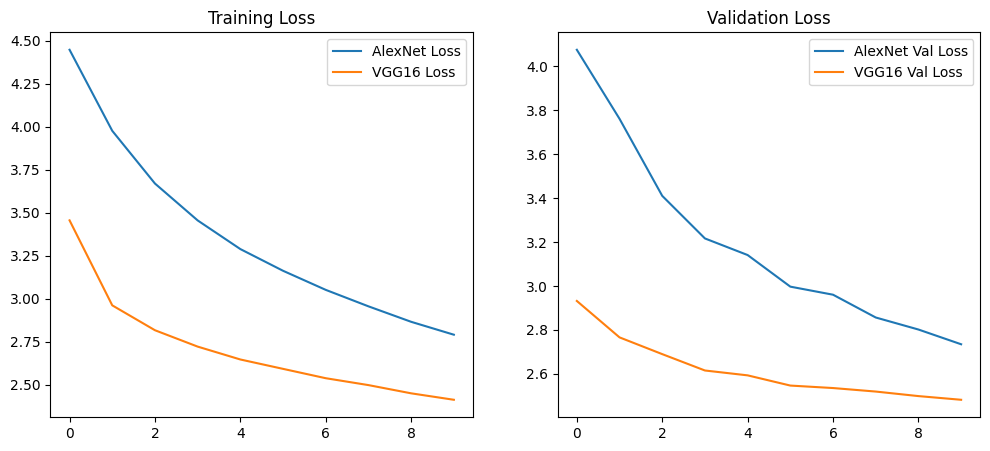

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(alexnet_history.history['accuracy'], label="AlexNet Accuracy")
plt.plot(vgg16_history.history['accuracy'], label="VGG16 Accuracy")
plt.legend()
plt.title("Training Accuracy")

plt.subplot(1, 2, 2)
plt.plot(alexnet_history.history['val_accuracy'], label="AlexNet Val Accuracy")
plt.plot(vgg16_history.history['val_accuracy'], label="VGG16 Val Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(alexnet_history.history['loss'], label="AlexNet Loss")
plt.plot(vgg16_history.history['loss'], label="VGG16 Loss")
plt.legend()
plt.title("Training Loss")

plt.subplot(1, 2, 2)
plt.plot(alexnet_history.history['val_loss'], label="AlexNet Val Loss")
plt.plot(vgg16_history.history['val_loss'], label="VGG16 Val Loss")
plt.legend()
plt.title("Validation Loss")

plt.show()


In [ ]:
print(f"Model\t\t| Test Accuracy\t| Test Loss\t| Training Time")
print("-" * 50)
print(f"AlexNet\t\t| {alexnet_eval[1]:.4f}\t\t| {alexnet_eval[0]:.4f}\t\t| {alexnet_time:.2f} sec")
print(f"VGG16\t\t| {vgg16_eval[1]:.4f}\t\t| {vgg16_eval[0]:.4f}\t\t| {vgg16_time:.2f} sec")


Model		| Test Accuracy	| Test Loss	| Training Time
--------------------------------------------------
AlexNet		| 0.3090		| 2.7346		| 110.46 sec
VGG16		| 0.3725		| 2.4819		| 180.54 sec
